In [13]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import getpass
from datetime import datetime
from tqdm.notebook import tqdm
from utils.basics import task_cmap_caps
from utils.basics import PNAS2015_subject_list, PNAS2015_folder, PNAS2015_roi_names_path, PNAS2015_win_names_paths, PRJ_DIR, input_datas, norm_methods

In [2]:
wls = 45
wss = 1.5
tr  = 1.5
win_names_path = PNAS2015_win_names_paths[(wls,wss)]
umap_min_dist    = 0.8
umap_init_method = 'spectral'
tsne_init_method = 'pca'

Given that we will use SI as a way to check optimal embeddings, we first load the results for the three modalities

In [3]:
si_LE = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_LE.pkl'))

In [4]:
si_UMAP = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_UMAP.pkl'))

In [5]:
si_TSNE = pd.read_pickle(osp.join(PRJ_DIR,'Dashboard','Data','si_TSNE.pkl'))

***
# Group Level - Procrustes

In [48]:
for input_data in input_datas:
    path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015','Procrustes','Classification','LE',input_data)
    if not osp.exists(path):
        print('++ INFO: Creating new folder [%s]' % path)
        os.makedirs(path)

++ INFO: Creating new folder [/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/Procrustes/Classification/LE/Original]
++ INFO: Creating new folder [/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/Procrustes/Classification/LE/Null_ConnRand]
++ INFO: Creating new folder [/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/Procrustes/Classification/LE/Null_PhaseRand]


In [9]:
_,_,le_best_nm, le_best_dist, le_best_knn, _, _ = si_LE.loc['Procrustes','Original',:,:,:,3,'Task'].sort_values(by='SI', ascending=False).iloc[0].name
print('++ INFO: Procrustes Group Level - Best Hyper parameters: [%s,%s,%d] --> %.2f' % (le_best_nm, le_best_dist, le_best_knn,si_LE.loc['Procrustes','Original',:,:,:,:,'Task'].sort_values(by='SI', ascending=False).iloc[0]))

++ INFO: Procrustes Group Level - Best Hyper parameters: [zscored,correlation,75] --> 0.49


In [64]:
#user specific folders
#=====================
username = getpass.getuser()
print('++ INFO: user working now --> %s' % username)

swarm_folder   = osp.join(PRJ_DIR,'SwarmFiles.{username}'.format(username=username))
logs_folder    = osp.join(PRJ_DIR,'Logs.{username}'.format(username=username))  

swarm_path     = osp.join(swarm_folder,'N15_Classify_GroupLevel_Procrustes_LE.SWARM.sh')
logdir_path    = osp.join(logs_folder, 'N15_Classify_GroupLevel_Procrustes_LE.logs')

if not osp.exists(swarm_folder):
    os.makedirs(swarm_folder)
if not osp.exists(logdir_path):
    os.makedirs(logdir_path)
print('++ INFO: Swarm File  : %s' % swarm_path)
print('++ INFO: Logs Folder : %s' % logdir_path)

++ INFO: user working now --> javiergc
++ INFO: Swarm File  : /data/SFIMJGC_HCP7T/manifold_learning_fmri/SwarmFiles.javiergc/N15_Classify_GroupLevel_Procrustes_LE.SWARM.sh
++ INFO: Logs Folder : /data/SFIMJGC_HCP7T/manifold_learning_fmri/Logs.javiergc/N15_Classify_GroupLevel_Procrustes_LE.logs


In [65]:
# Open the file
swarm_file = open(swarm_path, "w")
# Log the date and time when the SWARM file is created
swarm_file.write('#Create Time: %s' % datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
swarm_file.write('\n')

# Insert comment line with SWARM command
swarm_file.write('#swarm -J Clf_Group_LE_Procrustes -f {swarm_path} -b 20 -g 8 -t 8 --time 00:10:00 --partition quick,norm --logdir {logdir_path}'.format(swarm_path=swarm_path,logdir_path=logdir_path))
swarm_file.write('\n')


for input_data in input_datas:
        for clf in 'logisticregression','svc':
            for m in [2,3,5,10,15,20,25,30]:
                features = ','.join(['LE'+str(i+1).zfill(3) for i in range(m)])
                input_path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015','Procrustes','LE',input_data,'Procrustes_Craddock_0200.WL{wls}s.WS{wss}s.LE_{dist}_k{knn}_m{m}.{nm}.pkl'.format(nm=le_best_nm,dist=le_best_dist,knn=str(le_best_knn).zfill(4),
                                                                                                                                                   m=str(m).zfill(4),
                                                                                                                                                   wls=str(int(wls)).zfill(3), 
                                                                                                                                                   wss=str(wss)))
                output_path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015','Procrustes','Classification','LE',input_data,'Procrustes_Craddock_0200.WL{wls}s.WS{wss}s.LE_{dist}_k{knn}_m{m}.{nm}.clf_results.{clf}_WindowName.pkl'.format(nm=le_best_nm,dist=le_best_dist,knn=str(le_best_knn).zfill(4),
                                                                                                                                                   clf=clf,
                                                                                                                                                   wls=str(int(wls)).zfill(3),m=str(m).zfill(4),
                                                                                                                                                   wss=str(wss)))
                                        
                swarm_file.write("export input_path={input_path}  output_path={output_path} clf={clf} pid='Window Name' features='{features}' n_jobs=8; sh {scripts_dir}/N15_Classify.sh".format(
                       input_path = input_path, output_path=output_path, clf=clf, features=features,
                       scripts_dir=osp.join(PRJ_DIR,'Notebooks')))
                swarm_file.write('\n')
swarm_file.close()

In [6]:
import xarray as xr
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
%%time
LE_F1     = pd.DataFrame(columns=['Input','Subject','m','Classifier','F1'])
LE_COEFFS = {}
for m in tqdm([2,3,5,10,15,20,25,30],desc='Max Dimensions'):
    for input_data in input_datas:
        for clf in ['logisticregression','svc']:
            LE_COEFFS[(m,input_data,clf)] = xr.DataArray(dims=['Subject','Dimension','Class'], coords={'Subject':['Procrustes'],'Dimension':['LE'+str(i+1).zfill(4) for i in range(m)],'Class':['BACK','MATH','REST','VIDE']})
            # Load Classification results
            # ===========================
            path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015','Procrustes','Classification','LE',input_data,'Procrustes_Craddock_0200.WL045s.WS1.5s.LE_correlation_k0075_m{m}.zscored.clf_results.{clf}_WindowName.pkl'.format(m=str(m).zfill(4),clf=clf))
            with open(path,'rb') as f:
                objects = pickle.load(f)
            locals().update(objects)
            # Gather overall F1 - score
            # =========================
            LE_F1 = LE_F1.append({'Subject':'Procrustes','Input':input_data,'m':m,'Classifier':clf,
                                      'F1':cv_obj['test_f1_weighted'].mean()}, ignore_index=True)
                
            # Coefficients
            # ============
            df_coeffs = pd.DataFrame(columns=['Split','Class','Dimension','Coef'])
            for split in range(2):
                aux_class = list(lab_encs['Window Name'].inverse_transform(cv_obj['estimator'][split][clf].classes_))
                aux_coef  = cv_obj['estimator'][split][clf].coef_
                for ci,c in enumerate(aux_class):
                    for i in range(aux_coef.shape[1]):
                        df_coeffs = df_coeffs.append({'Split':split,'Class':c,'Dimension':feature_list[i],'Coef':abs(aux_coef[ci][i])},ignore_index=True)
            df_coeffs = df_coeffs.groupby(by=['Class','Dimension']).mean()
            df_coeffs.reset_index(inplace=True)
            df_coeffs = df_coeffs.pivot(index='Class',columns='Dimension',values='Coef').T
            LE_COEFFS[(m,input_data,clf)].loc['Procrustes',:,:] = df_coeffs
            del df_coeffs

Max Dimensions:   0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 19.7 s, sys: 25.9 s, total: 45.6 s
Wall time: 11.5 s


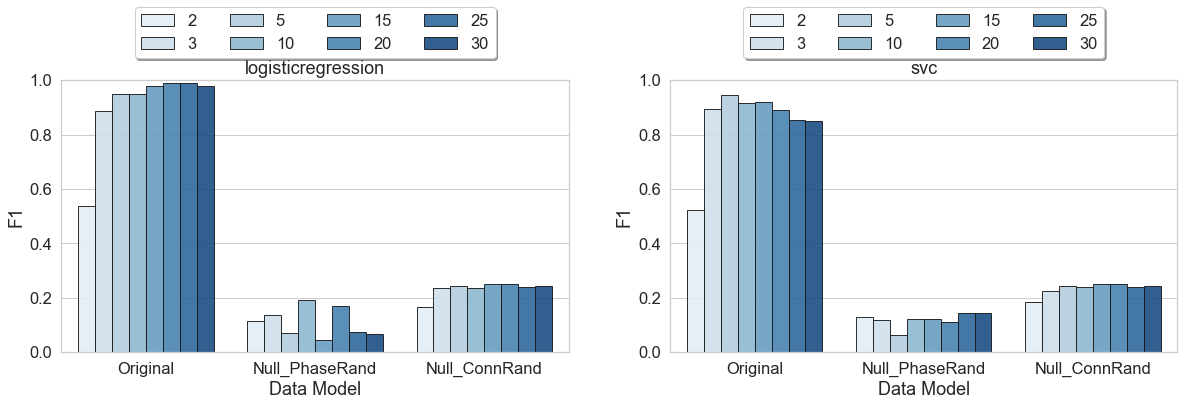

In [25]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = LE_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1',x='Input',hue='m', ax=axs[i], alpha=.9, palette=sns.color_palette('Blues',8), edgecolor='k')
    #g = sns.swarmplot(data=aux_df,y='F1',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)
    g.set_xlabel('Data Model')

Text(0.5, 1.0, 'Logistic Regression')

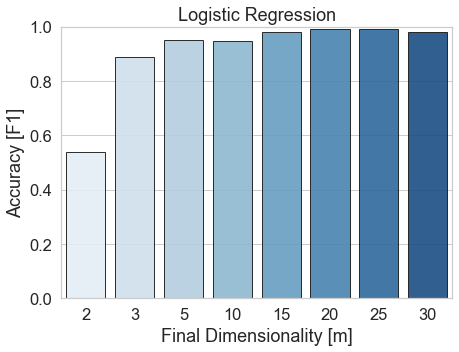

In [37]:
sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(1,1,figsize=(7,5))
aux_df = LE_F1[LE_F1['Input']=='Original'].set_index(['Classifier']).sort_index().loc['logisticregression'].sort_values(by='Input', ascending=False)
g = sns.barplot(data=aux_df,y='F1',x='m', ax=ax, alpha=.9, palette=sns.color_palette('Blues',8), edgecolor='k')
g.set_ylim(0,1)
#g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)
g.set_xlabel('Final Dimensionality [m]');
g.set_ylabel('Accuracy [F1]');
g.set_title('Logistic Regression')

Text(0, 0.5, 'Logistic Regression Coefficients')

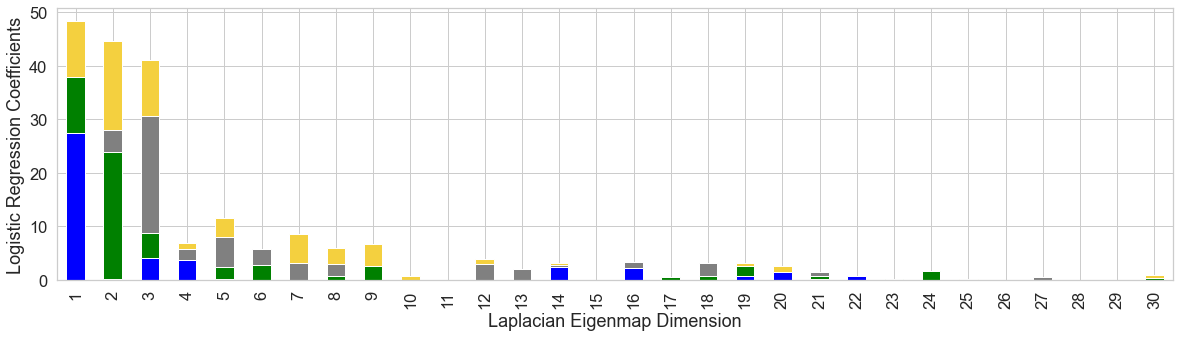

In [48]:
sns.set(font_scale=1.5, style='whitegrid')
fig, ax = plt.subplots(1,1,figsize=(20,5))
df_summary = LE_COEFFS[(30,'Original','logisticregression')].mean(dim='Subject').to_dataframe(name='Coeffs')
df_summary = df_summary.groupby(by=['Class','Dimension']).mean()
df_summary.reset_index(inplace=True)
df_summary = df_summary.pivot(index='Class',columns='Dimension',values='Coeffs').T
df_summary.index = [str(i+1) for i in range(30)]
df_summary.index.name = 'Laplacian Eigenmap Dimension'
df_summary.plot(kind='bar',stacked=True, legend=None, color=task_cmap_caps, ax=ax)
ax.set_ylabel('Logistic Regression Coefficients')
#ax.set_ylim(0,20)
#ax.set_title('Data: %s' % input_data)

In [52]:
LE_COEFFS[(25,
  'Original',
  'logisticregression')]

<xarray.DataArray (Subject: 1, Dimension: 25, Class: 4)>
array([[[26.60905981,  9.79520239,  0.4223304 , 11.3247309 ],
        [ 0.11517651, 22.82144697,  5.10020611, 15.45039245],
        [ 3.99664491,  5.22794845, 22.96842506, 11.08983756],
        [ 3.76789876,  0.        ,  0.94952063,  0.        ],
        [ 0.4932887 ,  2.39940119,  6.52415575,  3.60840576],
        [ 0.        ,  3.54470787,  2.58184226,  0.80462002],
        [ 0.        ,  0.        ,  3.88115811,  4.76808229],
        [ 0.        ,  0.75550624,  1.75445398,  2.53959809],
        [ 0.03890036,  2.22925023,  0.        ,  3.58736129],
        [ 0.        ,  0.        ,  0.        ,  0.87809818],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  2.18239362,  1.41409108],
        [ 0.        ,  0.        ,  1.1354403 ,  0.        ],
        [ 2.56141212,  0.        ,  0.        ,  0.85415399],
        [ 0.03214863,  0.        ,  0.        ,  0.        ],
        [ 2.54930844,  0.        ,  1.3790281 ,  0.98911526],
        [ 0.08962757,  0.83653498,  0.        ,  0.        ],
        [ 0.        ,  1.06157819,  1.3912521 ,  0.        ],
        [ 1.57074537,  2.35937082,  1.17505641,  0.75483484],
        [ 1.82935233,  0.        ,  0.        ,  2.1712805 ],
        [ 0.        ,  0.        ,  1.32377194,  0.        ],
        [ 1.99345438,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.04977822,  0.32298975,  0.        ],
        [ 0.        ,  2.39118005,  0.        ,  0.78584061],
        [ 0.        ,  0.        ,  0.        ,  0.31778066]]])
Coordinates:
  * Subject    (Subject) <U10 'Procrustes'
  * Dimension  (Dimension) <U6 'LE0001' 'LE0002' 'LE0003' ... 'LE0024' 'LE0025'
  * Class      (Class) <U4 'BACK' 'MATH' 'REST' 'VIDE'

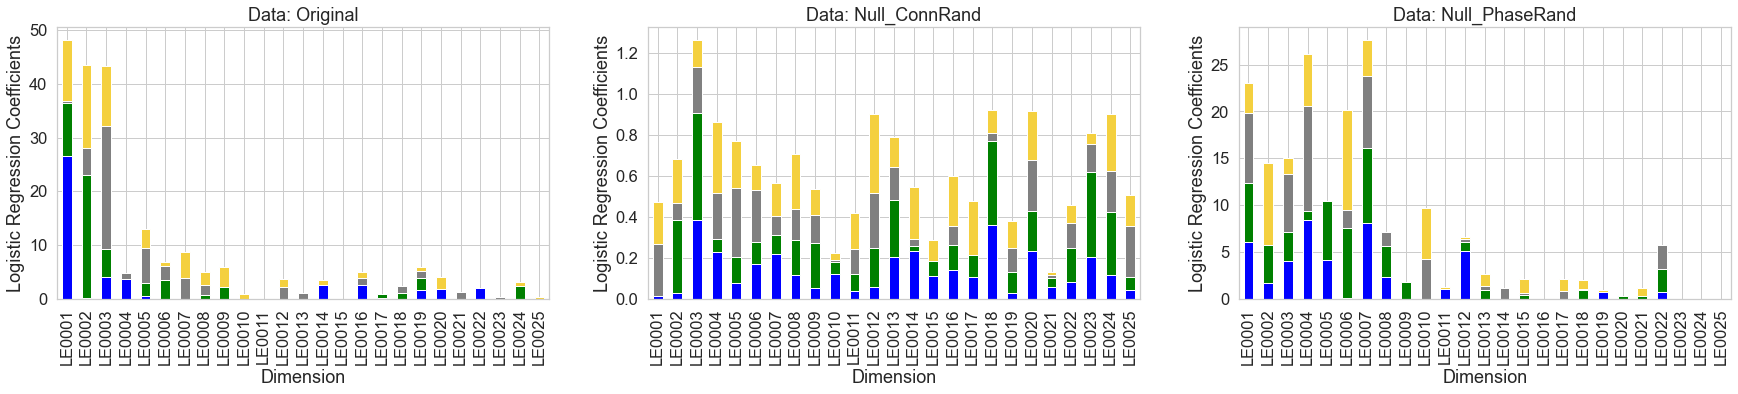

In [15]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,3,figsize=(30,5))
for i, input_data in enumerate(input_datas):
    df_summary = LE_COEFFS[(25,input_data,'logisticregression')].mean(dim='Subject').to_dataframe(name='Coeffs')
    df_summary = df_summary.groupby(by=['Class','Dimension']).mean()
    df_summary.reset_index(inplace=True)
    df_summary = df_summary.pivot(index='Class',columns='Dimension',values='Coeffs').T
    df_summary.plot(kind='bar',stacked=True, legend=None, color=task_cmap_caps, ax=axs[i])
    axs[i].set_ylabel('Logistic Regression Coefficients')
    #axs[i].set_ylim(0,20)
    axs[i].set_title('Data: %s' % input_data)

In [11]:
LE_COEFFS

{(2,
  'Original',
  'logisticregression'): <xarray.DataArray (Subject: 1, Dimension: 2, Class: 4)>
 array([[[10.47850883,  2.34906771,  0.60113288,  4.08393404],
         [ 1.74054996,  8.08214501,  2.94173726,  3.07183937]]])
 Coordinates:
   * Subject    (Subject) <U10 'Procrustes'
   * Dimension  (Dimension) <U6 'LE0001' 'LE0002'
   * Class      (Class) <U4 'BACK' 'MATH' 'REST' 'VIDE',
 (2,
  'Original',
  'svc'): <xarray.DataArray (Subject: 1, Dimension: 2, Class: 4)>
 array([[[8.70858522, 5.89613322, 7.72040423, 0.64395161],
         [3.5469173 , 3.6579528 , 0.78677699, 6.46768419]]])
 Coordinates:
   * Subject    (Subject) <U10 'Procrustes'
   * Dimension  (Dimension) <U6 'LE0001' 'LE0002'
   * Class      (Class) <U4 'BACK' 'MATH' 'REST' 'VIDE',
 (2,
  'Null_ConnRand',
  'logisticregression'): <xarray.DataArray (Subject: 1, Dimension: 2, Class: 4)>
 array([[[0.12062567, 0.30782475, 0.08311433, 0.11131106],
         [0.01334387, 0.08418126, 0.00045217, 0.10275945]]])
 Coordinates